In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
import itertools

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
import mydata as md

In [ ]:
from geopy.distance import geodesic

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
# ###Setting the map to be used for location estimation
H = 51
W = 68
MAP_SIZE = 3468 #Number of areas (H * W)

num_dataset_in_one_place = 500

In [ ]:
INPUT_FEATURES = 4
LAYER1_NEURONS = 20
LAYER2_NEURONS = 20
LAYER3_NEURONS = 10
OUTPUT_RESULTS = MAP_SIZE
ACTIVATION = 'ReLU'


model = tf.keras.models.Sequential([
                                    
  tf.keras.layers.Dense(
    input_shape=(INPUT_FEATURES,),
    name = "hidden_layer1",
    units=LAYER1_NEURONS,
    activation=ACTIVATION),

    tf.keras.layers.Dense(
    name = "hidden_layer2",
    units= LAYER2_NEURONS,
    activation=ACTIVATION),

  tf.keras.layers.Dense(
    name = "hidden_layer3",
    units= LAYER3_NEURONS,
    activation=ACTIVATION),

  tf.keras.layers.Dense(
    name= "output_layer",
    units=OUTPUT_RESULTS,
    activation='softmax'),
])

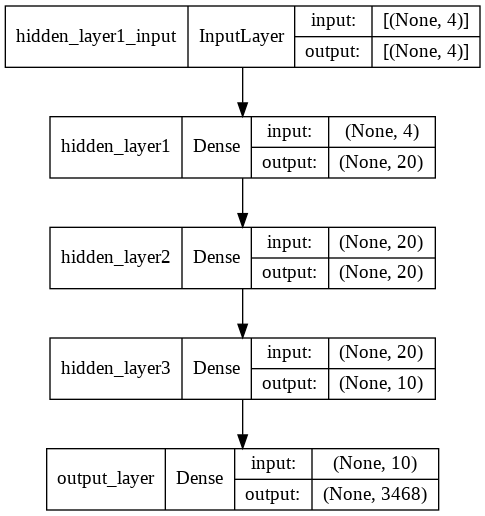

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=False, filename='model.png')

In [ ]:
# ### Settings ###
LOSS = 'categorical_crossentropy'
OPTIMIZER = tf.keras.optimizers.SGD
LEARNING_RATE = 0.003
BATCH_SIZE = 10
EPOCHS = 50

In [ ]:
# ###　Data Acquisition ###
x_train, y_train, y_train_true =  md.mkData('/content/drive/My Drive/Colab Notebooks/training_dataset_WiFi_1.csv',num_dataset_in_one_place)
x_valid, y_valid, y_valid_true=  md.mkData('/content/drive/My Drive/Colab Notebooks/verification_dataset_WiFi_1.csv',num_dataset_in_one_place)

In [ ]:
md.shuffle(x_train,y_train,y_train_true)
md.shuffle(x_valid,y_valid,y_valid_true)

(array([[0.63095734, 0.12589254, 0.25118864, 0.12589254],
        [0.06309573, 0.02511886, 0.03981072, 0.39810717],
        [0.79432823, 0.01584893, 0.06309573, 0.1       ],
        ...,
        [0.31622777, 0.12589254, 0.25118864, 0.1       ],
        [0.03981072, 0.03981072, 0.06309573, 0.79432823],
        [0.07943282, 0.03162278, 0.31622777, 0.79432823]]),
 array([2277, 2088, 2499, ..., 2277, 1732, 1041]),
 array([[ 35.1586219, 136.9240414],
        [ 35.1586543, 136.9241882],
        [ 35.1585882, 136.9242245],
        ...,
        [ 35.1586219, 136.9240414],
        [ 35.1586987, 136.9240287],
        [ 35.1588048, 136.923919 ]]))

In [ ]:
# ### Label distribution learning ###
def mk_dist_label(y_lavel):
  cov  = np.array([[1.0,0.0],[0.0,1.0]])
  res = []
  y_two_dim = []
  memo = {}
  for i in y_train:
    y_two_dim.append((i//W, i%W))
  for p in y_two_dim:
    if p in memo:
      res.append(memo[p])
    else:
      label_dist = np.array([[0.0 for i in range(W)] for i in range(H) ])
      for i in range(H):
        for j in range(W):
          label_dist[i][j] = multivariate_normal.pdf(np.array([i,j]),np.array(p),cov)
      label_dist = label_dist.flatten()
      res.append(list(label_dist))
      memo[p] = list(label_dist)
  return res

In [ ]:
x_train = tf.constant(x_train)
y_train_dist = tf.constant(np.array(mk_dist_label(y_train)))
x_valid = tf.constant(x_valid)
y_valid_dist = tf.constant(np.array(mk_dist_label(y_valid)))

In [ ]:
model.compile(optimizer=OPTIMIZER(learning_rate=LEARNING_RATE), 
              loss=LOSS,
              metrics=['CategoricalCrossentropy'])

In [ ]:
hist = model.fit(x=x_train,
                 y=y_train_dist,
                 validation_data=(x_valid, y_valid_dist),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1)

Epoch 1/50
650/650 [==============================] - 4s 5ms/step - loss: 8.1445 - categorical_crossentropy: 8.1445 - val_loss: 8.1389 - val_categorical_crossentropy: 8.1389
Epoch 2/50
650/650 [==============================] - 2s 4ms/step - loss: 8.1321 - categorical_crossentropy: 8.1321 - val_loss: 8.1268 - val_categorical_crossentropy: 8.1268
Epoch 3/50
650/650 [==============================] - 2s 4ms/step - loss: 8.1194 - categorical_crossentropy: 8.1194 - val_loss: 8.1143 - val_categorical_crossentropy: 8.1143
Epoch 4/50
650/650 [==============================] - 3s 4ms/step - loss: 8.1061 - categorical_crossentropy: 8.1061 - val_loss: 8.1011 - val_categorical_crossentropy: 8.1011
Epoch 5/50
650/650 [==============================] - 2s 4ms/step - loss: 8.0917 - categorical_crossentropy: 8.0917 - val_loss: 8.0868 - val_categorical_crossentropy: 8.0868
Epoch 6/50
650/650 [==============================] - 3s 4ms/step - loss: 8.0756 - categorical_crossentropy: 8.0756 - val_loss: 8.

In [ ]:
#Visualize the location of the correct answer and the predicted location.
def viewpred(true_data, pred_data, error):
  UPPER_LEFT = np.array([35.158950,136.923782])
  UPPER_RIGHT = np.array([35.158892, 136.924371])
  LOWER_LEFT = np.array([35.158503, 136.923713])
  LOWER_RIGHT = np.array([35.158446, 136.924302])
  ANCHOR = np.concatenate([[UPPER_LEFT],[UPPER_RIGHT],[LOWER_LEFT],[LOWER_RIGHT]],axis=0)
  plt.scatter(true_data[1],true_data[0],color='blue',label='true')
  plt.scatter(pred_data[1],pred_data[0],color='green',label='pred')
  plt.scatter(ANCHOR[:,1],ANCHOR[:,0],color='red',marker='.')
  plt.xlabel('keido')
  plt.ylabel('ido')
  plt.text(UPPER_LEFT[1],UPPER_LEFT[0],"true_location = " + str(true_data))
  plt.text(LOWER_LEFT[1],LOWER_LEFT[0],"error = "+ str(error) + "m")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
  plt.show()

In [ ]:
#Evaluate the error between the correct position and the predicted position using Euclidean distance.
#Visualize the location of the correct answer and the predicted location.
def valuedist(y_true, y_pred):
  num_pos = len(y_true)//num_dataset_in_one_place
  y_pred = md.localize(y_pred)
  dict = {}
  for p1,p2 in zip(y_true, y_pred):
      p1 = tuple(p1)
      if p1 in dict:
        dict[p1].append(p2)
      else:
        dict[p1] = [p2]
  list_error = []
  for k,v in dict.items():
    ave_pred_pos = np.mean(v, axis=0)
    error = geodesic(k, list(ave_pred_pos)).m
    list_error.append(error)
    viewpred(k,ave_pred_pos,error)
  return np.mean(np.array(list_error)),max(list_error)

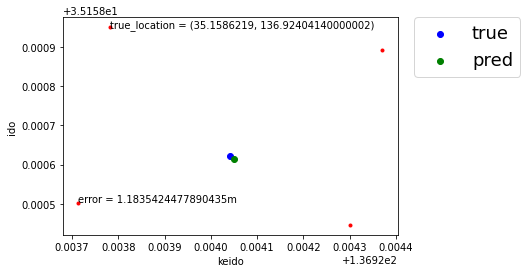

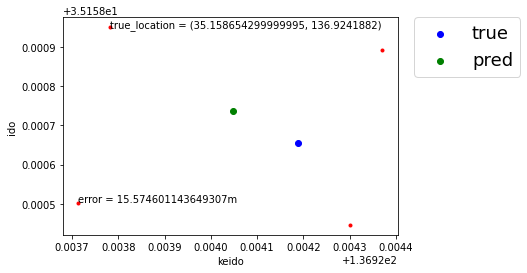

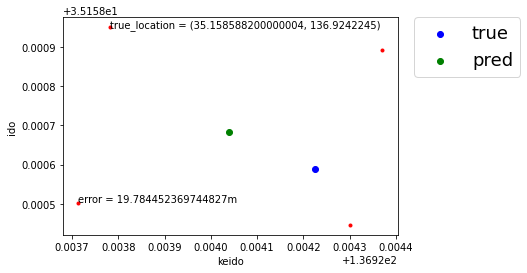

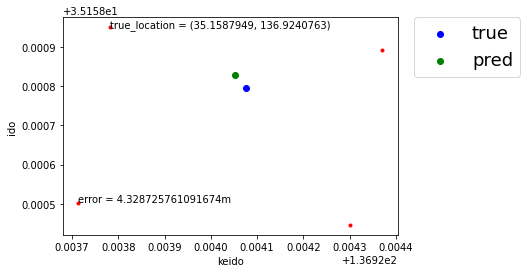

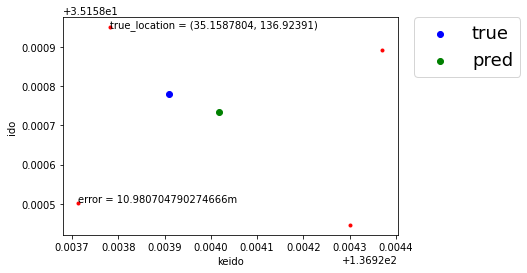

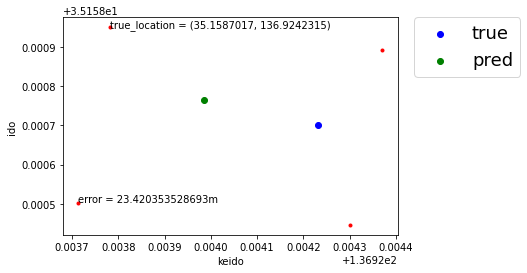

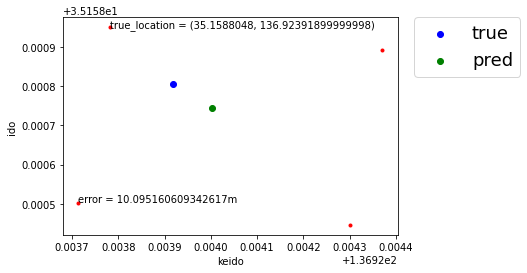

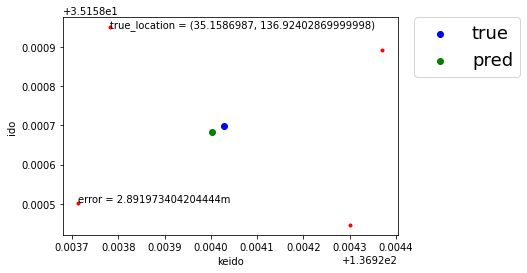

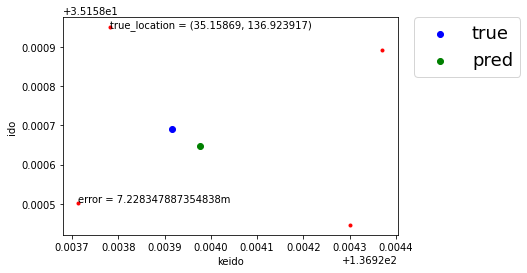

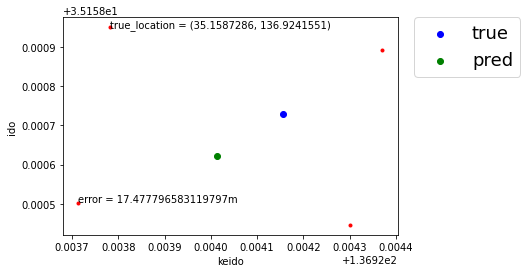

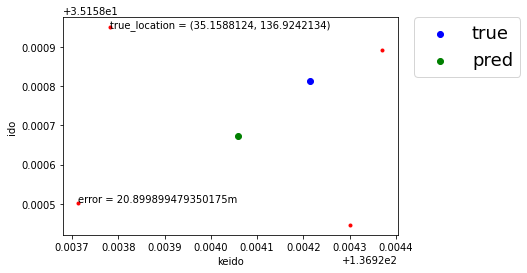

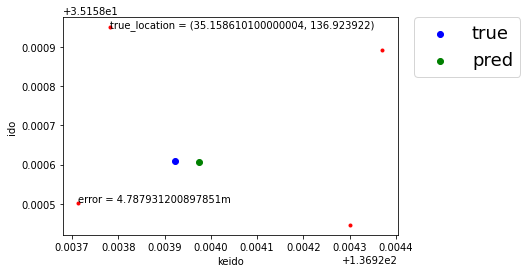

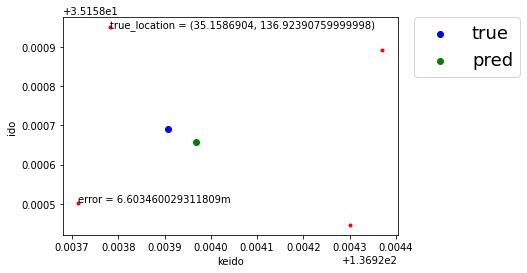

(11.173611479601849, 23.420353528693)

In [ ]:
#Evaluate the error between the correct position and the predicted position using Euclidean distance.
y_prob = model.predict(x_valid)
y_pred = []
for i in y_prob:
  y_pred.append(np.argmax(i))
y_pred = np.array(y_pred)
valuedist(y_valid_true,y_pred)

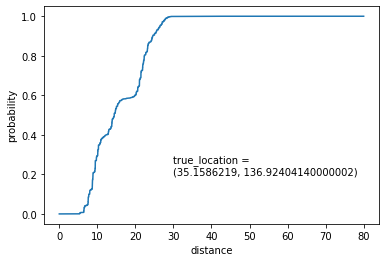

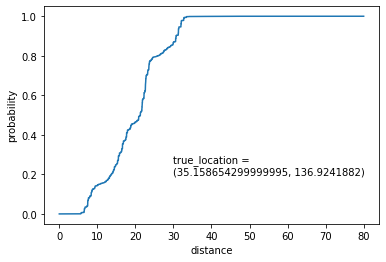

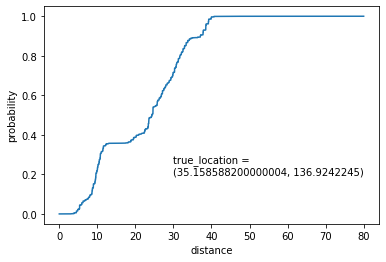

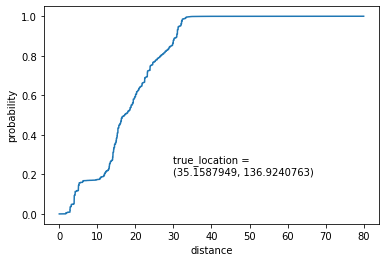

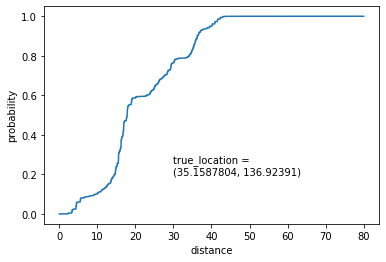

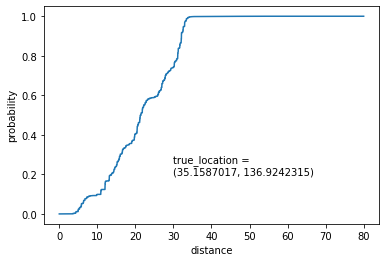

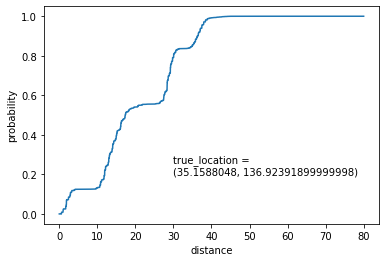

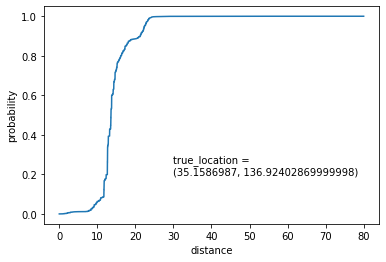

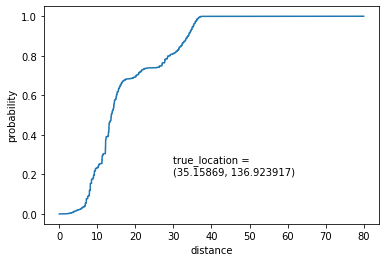

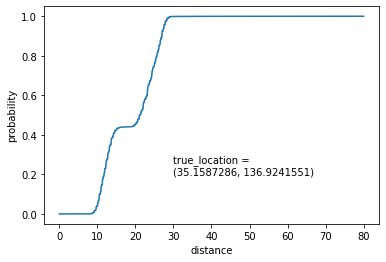

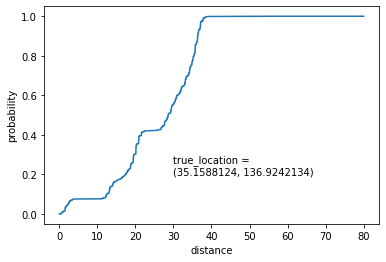

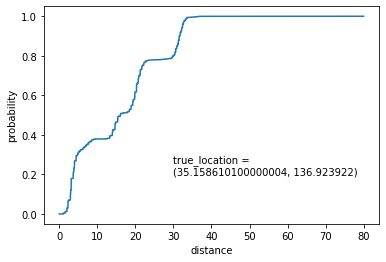

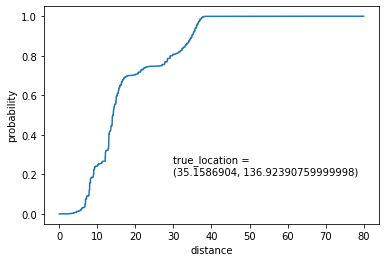

In [ ]:
#extra
dict = {}
for p1,p2 in zip(y_valid_true, y_prob):
    p1 = tuple(p1)
    if p1 in dict:
      dict[p1] += p2
    else:
      dict[p1] = p2
for p1 in dict.keys():
    dict[p1] /= np.array([num_dataset_in_one_place])
for k,v in dict.items():
  y = [0.0 for i in range (8000)] 
  x = np.linspace(0,80,8000)
  for i in range(MAP_SIZE):
    dist = geodesic(k,md.localize([i])[0]).m
    y[(int)(dist*100)] += v[i]
  for i in range(1,len(y)):
    y[i] += y[i-1]
  plt.plot(x,y)
  plt.text(30,0.2,"true_location = \n" + str(k))
  plt.xlabel('distance')
  plt.ylabel('probability')
  plt.show()